In [5]:

import jax.numpy as jnp

import sys
sys.path.insert(1,'..')

import utils
import loader
import tqdm
%load_ext autoreload
%autoreload 2
import imp
imp.reload(loader)
import setup
import scipy.stats as sts
from matplotlib import pyplot as plt

import numpy as np

/Users/jbarbosa/anaconda3/envs/netrep/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-07-18 19:22:00,991	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
/Users/jbarbosa/anaconda3/envs/netrep/lib/python3.11/site-packages/ibllib/atlas/__init__.py:205: DeprecationWarning: ibllib.atlas is deprecated. Please install iblatlas using "pip install iblatlas" and use this module instead
  warnings.warn('ibllib.atlas is deprecated. Please install iblatlas using "pip install iblatlas" and use '


In [2]:
# load data 
with(open("100_avg_folds_response_aligned.pkl","rb")) as f:
    import pickle
    params,_ys,train_data_folds,test_data_folds = pickle.load(f)
    

In [58]:
n_folds = 10
w = 10
all_corrs = np.zeros((n_folds,len(_ys[0])-w))*np.nan


for fold in range(n_folds):
    
    train_fold, test_fold = train_data_folds[fold],test_data_folds[fold]
    ys_time,_ = zip(*train_fold)
    _,cs_time = zip(*test_fold)

    # fitler out sessions with too few neurons or trials
    min_neurons = 100
    min_trials = 20

    valid = [i for i in range(len(ys_time)) if np.array(_ys[i]).shape[-1] >= min_neurons and np.array(_ys[i]).shape[1] >= min_trials]
    ys_time = [ys_time[i] for i in valid]
    cs = [cs_time[i] for i in valid]

    S = len(ys_time)


    for t in tqdm.trange(len(ys_time[0])-w):

        # get best min_neurons and current time point +window
        all_sessions = []
        for session in range(S):
            ys_sess = ys_time[session][t:t+w,:].reshape(-1,ys_time[session].shape[-1])
            ys_sess = ys_sess[:,np.argsort(ys_sess.std(0))][:,:min_neurons]
            all_sessions.append(ys_sess)

        try:
            dist_neural = utils.dsd([
                [all_sessions[i],all_sessions[j]]
                for i in range(S) 
                for j in range(S)]
            ).reshape(S,S)


            dist_cc = np.zeros((S,S))
            for i in range(S):
                for j in range(S):
                    dist_cc[i,j] = np.mean(np.abs(cs[i]- cs[j]))

            corr = sts.pearsonr(dist_neural[~jnp.eye(dist_neural.shape[0],dtype=bool)],
                    dist_cc[~jnp.eye(dist_cc.shape[0],dtype=bool)])[0]
            
        except Exception as e:

            print(t,fold,"linalg error/nan")
            continue
        
        all_corrs[fold,t]=corr




 12%|█▏        | 17/140 [00:20<02:30,  1.22s/it]

16 0 linalg error/nan


 42%|████▏     | 59/140 [01:13<02:00,  1.49s/it]

58 0 linalg error/nan


 95%|█████████▌| 133/140 [02:51<00:06,  1.07it/s]

132 0 linalg error/nan


  0%|          | 0/140 [00:00<?, ?it/s]


KeyboardInterrupt: 

/var/folders/6w/snfd5vc50jb775fq8364m1d80000gn/T/ipykernel_2823/3926579151.py:5: RuntimeWarning: Mean of empty slice
  plt.plot(x_time,np.nanmean(all_corrs,0),color="r")
/Users/jbarbosa/anaconda3/envs/netrep/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1556: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,


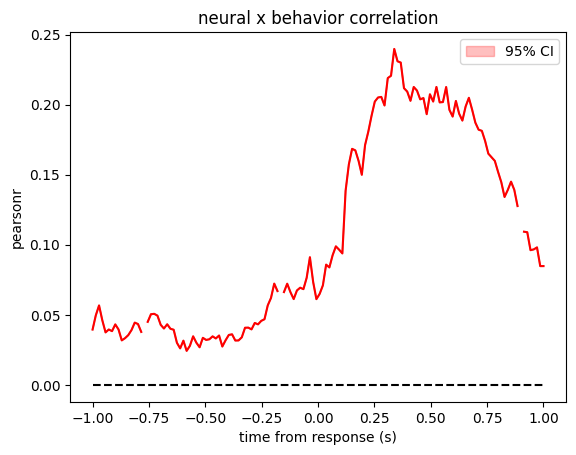

In [61]:
from matplotlib import pyplot as plt
x_time = np.linspace(-1,1,len(all_corrs[0]))
#x_time -= np.diff(x_time)[0]*w
plt.plot(x_time,all_corrs.T,color="k",alpha=0.1)
plt.plot(x_time,np.nanmean(all_corrs,0),color="r")
plt.plot(x_time,np.zeros_like(x_time),'--',color='k')
plt.fill_between(x_time,[np.nanpercentile(a,2.5) for a in all_corrs.T],[np.nanpercentile(a,97.5) for a in all_corrs.T],color='r',alpha=0.25,label='95% CI')
plt.xlabel('time from response (s)')
plt.ylabel('pearsonr')
plt.title('neural x behavior correlation')
plt.legend()
